In [247]:
%load_ext autoreload
%autoreload 2

import os
from jax import config
config.update("jax_enable_x64", True)

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID" 
os.environ["CUDA_VISIBLE_DEVICES"] = '1'
from gpu_utils import limit_gpu_memory_growth
limit_gpu_memory_growth()


from pixel_cnn  import train_pixel_cnn       
import tensorflow_datasets as tfds  # TFDS for MNIST
import tensorflow as tf             # TensorFlow operations

from image_distribution_models import PixelCNN

from cleanplots import *
import jax.numpy as np
from jax.scipy.special import logsumexp



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [248]:
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.mnist.load_data()


# import numpy as onp
# train_images = onp.random.randint(0, 255, train_images.shape).astype('uint8')

# # make some bimodal IID data
# train_images = onp.where(onp.random.rand(*train_images.shape) > 0.5, 250, 5) + onp.random.normal(0, 10, train_images.shape)



In [241]:
# Generate gaussian mixture IID pixel values

import jax
from tqdm import tqdm
n_images = 8000
image_size = 28
# image_size = 5

# Number of Gaussian components
n_components = 7

# Randomly generate means, std_devs, and weights
onp.random.seed(5)  # For reproducibility
means = onp.random.uniform(0, 255, n_components)
std_devs = onp.random.uniform(1, 50, n_components)
weights = onp.random.dirichlet(onp.ones(n_components), size=1).flatten()

# Initialize array to store images
images = []

# Vectorized image generation
for i in tqdm(range(n_images)):
    # Generate component indices based on weights
    component_indices = onp.random.choice(n_components, size=(image_size, image_size), p=weights)
    
    # Draw from Gaussians
    key = jax.random.PRNGKey(i)
    # pixel_values = onp.random.normal(means[component_indices], std_devs[component_indices])
    pixel_values = means[component_indices] + std_devs[component_indices] * jax.random.normal(key, shape=(image_size, image_size))
    
    # Clip to [0, 255]
    pixel_values = np.clip(pixel_values, 0, 255)
    
    images.append(pixel_values)

train_images = np.array(images)
train_images = np.where(train_images > 0, train_images, 0)


100%|██████████| 8000/8000 [00:11<00:00, 722.76it/s]


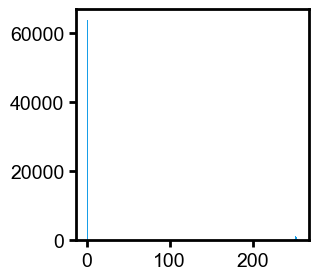

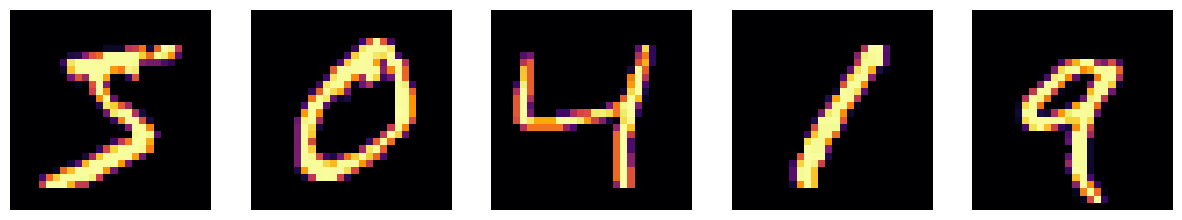

In [249]:
# histogram of pixel values
fig, ax = plt.subplots(1,1, figsize=(3,3))
ax.hist(train_images[:100].flatten(), bins=256)

# plot a few images
fig, ax = plt.subplots(1,5, figsize=(15,3))
for i in range(5):
    ax[i].imshow(train_images[i], cmap='inferno')
    ax[i].axis('off')

## Plot the untrained distributions for each pixel

Initial validation NLL: 151.17


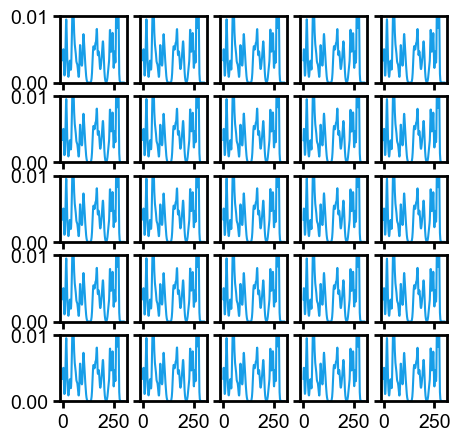

In [233]:
num = 5
# num = 28


pixel_cnn = PixelCNN()
pixel_cnn.fit(train_images, 
                            num_hidden_channels=64, num_mixture_components=40,
            max_epochs=0, steps_per_epoch=200, patience=10, batch_size=128, num_val_samples=1000, verbose=True)

# evaluate the probability at each pixel
y = np.linspace(-1, 258, 300).reshape(-1, 1, 1, 1, 1)
mu, sigma, log_mix = pixel_cnn._pixel_cnn_flax.forward_pass(train_images[:1][..., None])
nll = - logsumexp(log_mix - logsumexp(log_mix, axis=-1, keepdims=True) + pixel_cnn._pixel_cnn_flax.lognormal(y, mu, sigma), axis=-1)

probs = np.exp(-nll[:, 0, :num, :num])
# probs = -nll[:, 0, :num, :num]

fig, ax = plt.subplots(num, num, figsize=(num, num), sharex=True, sharey=True)
for i in range(num):
    for j in range(num):
        ax[i,j].plot(probs[..., i, j])
        ax[i,j].set_ylim(0, 0.01)

        

In [ ]:
mix = np.exp(log_mix - logsumexp(log_mix, axis=-1, keepdims=True))
assert np.allclose(mix.sum(-1), 1)

mix[0, 0, 3, :]
mu[0, 0, 3, :]


sigma[0, 0, 3, :]

Array([ 25.84231545,   0.        ,  17.44116827,  24.25793894,
        75.01287698,  20.65723465,  63.94159878,   0.        ,
       155.84876462,  79.5756415 , 172.78562988, 158.59538796,
       139.06059287, 258.26475156, 219.5640879 ,  17.7028544 ,
       148.27527348, 131.86903923, 258.59662334, 263.25627975,
       254.10263028, 264.66224101,  31.61949067,  80.62911908,
       213.72079988, 234.2785413 , 183.82360532, 229.44607265,
         0.        , 244.29710402,  14.25132485, 142.21717142,
         0.        , 128.70998853, 225.3508243 , 254.116613  ,
       181.29644162,  41.78767191,   3.12696293,  57.27228457],      dtype=float64)

## Now train and compare

In [250]:
pixel_cnn = PixelCNN()
pixel_cnn.fit(train_images, max_epochs=10, steps_per_epoch=10, patience=10, batch_size=128, num_val_samples=1000, 
              num_hidden_channels=64, num_mixture_components=40,
              learning_rate=1e-2, verbose=True)

Initial validation NLL: 5087.35


Epoch 1: validation NLL: 1534.11


Epoch 2: validation NLL: 1385.48


Epoch 3: validation NLL: 1353.62


Epoch 4: validation NLL: 1320.22


Epoch 5: validation NLL: 1301.42


Epoch 6: validation NLL: 1296.16


Epoch 7: validation NLL: 1281.49


Epoch 8: validation NLL: 1278.93


Epoch 9: validation NLL: 1274.39


Epoch 10: validation NLL: 1275.83


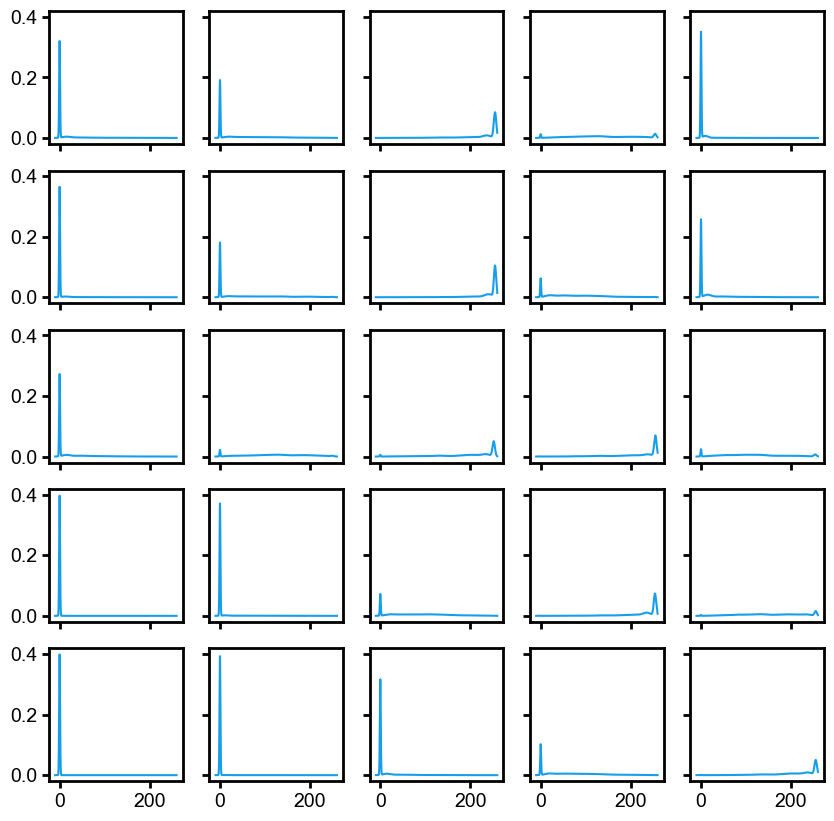

In [252]:
start = 10
end = 15
# num = 5
# num = 28

# evaluate the probability at each pixel
y = np.linspace(-10, 260, 1000).reshape(-1, 1, 1, 1, 1)
mu, sigma, log_mix = pixel_cnn._pixel_cnn_flax.forward_pass(train_images[:1][..., None])
nll = - logsumexp(log_mix - logsumexp(log_mix, axis=-1, keepdims=True) + pixel_cnn._pixel_cnn_flax.lognormal(y, mu, sigma), axis=-1)

mix = np.exp(log_mix - logsumexp(log_mix, axis=-1, keepdims=True))

probs = np.exp(-nll[:, 0, start:end, start:end])
# probs = -nll[:, 0, :num, :num]

fig, ax = plt.subplots(end-start, end-start, figsize=(10, 10), sharex=True, sharey=True)
for i in range(end-start):
    for j in range(end-start):
        ax[i,j].plot(y.ravel(), probs[..., i, j])
        # ax[i,j].set_ylim(0, .01)


11.742797533827739
1.0
58.66489742102063
97.68927014378136


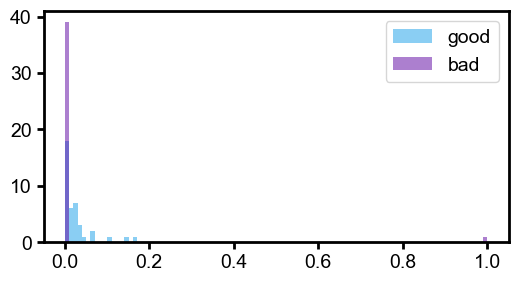

In [ ]:
mix = np.exp(log_mix - logsumexp(log_mix, axis=-1, keepdims=True))
assert np.allclose(mix.sum(-1), 1)

mix[0, 0, 3, :]
mu[0, 0, 3, :]
# log_sigma[0, 0, 2, :]

i, j = 1, 3

fig, ax = plt.subplots(1,1, figsize=(6,3))
_ = ax.hist(mix[0, 0, 0, :], bins=np.linspace(0,1,100), label='good', alpha=0.5)
ax.hist(mix[0, i, j, :], bins=np.linspace(0,1,100), label='bad', alpha=0.5)
ax.legend()

for k, l in [(0,0), (i,j)]:
    m = np.argmax(mix[0, k, l, :])
    print(sigma[0, k, l, m])

for k, l in [(0,0), (i,j)]:
    m = np.argmax(mix[0, k, l, :])
    print(mu[0, k, l, m])